# Reproducing "Deep Bayesian Active Learning with Image Data"

Imports

In [ ]:
# PyTorch
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader

# Other
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import sys

Constants

In [ ]:
T = 20
NUM_CLASSES = 10
EPOCHS = 50
INIT_TRAIN_SIZE = 20
VALID_SIZE = 100
BATCH_SIZE = 128
POOL_BATCH_SIZE = 128
SUBPOOL_SIZE = 10_000
EPSILON = sys.float_info.min
ACQ_SIZE = 10
ACQ_STEPS = 100
REPS = 3
CPU = "cpu"
CUDA = "cuda"
DEVICE = torch.device(CUDA if torch.cuda.is_available() else CPU)
WDS = [
    0.5e-2, 1e-2,
    0.5e-3, 1e-3,
    0.5e-4, 1e-4,
    0.5e-5, 1e-5,
    0.5e-6, 1e-6
]
NUM_WORKERS = 2


Plot

In [ ]:
# data: list of {"data": [], "label": str, "color": str}
def plot_graph(data, std=False):
  x = [i*ACQ_SIZE for i in range(ACQ_STEPS+1)]

  for line in data:
    y = np.mean(line["data"], axis=0)
    plt.plot(x,y, label=line["label"], color=line["color"])
    if std:
      y_std = np.std(line["data"], axis=0)
      plt.fill_between(x, y - y_std, y + y_std, color=line["color"], alpha=0.2)

  plt.ylim(80.0, 100.0)

  plt.xticks(np.arange(0, 1100, 100))
  plt.yticks(np.arange(80.0, 102.0, 2.0))

  plt.legend(loc='lower right')
  plt.grid(linestyle='--')
  plt.show()


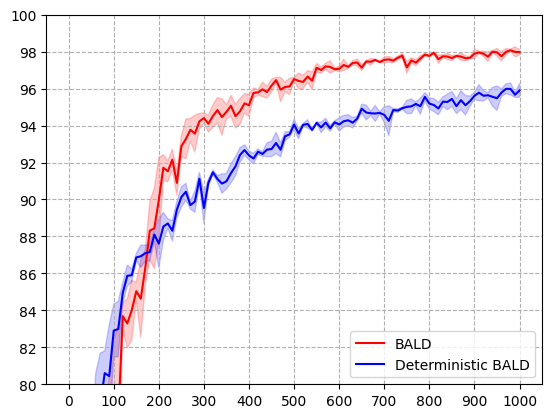

In [ ]:
bald_data = [[55.4, 59.86, 64.73, 62.08, 75.12, 74.14, 77.32, 77.13, 78.46, 79.02, 83.32, 75.92, 83.55, 81.4, 83.28, 85.3, 81.91, 84.93, 86.29, 86.56, 86.75, 92.68, 92.3, 92.95, 91.59, 93.65, 94.48, 94.32, 94.56, 94.51, 94.18, 94.08, 95.19, 95.32, 95.24, 94.21, 95.41, 95.0, 94.51, 94.46, 95.82, 95.79, 96.01, 96.49, 95.78, 96.64, 96.42, 96.74, 96.29, 95.5, 96.58, 96.8, 96.67, 96.5, 95.76, 97.27, 96.95, 97.44, 96.91, 96.97, 97.2, 97.61, 97.25, 97.41, 97.32, 97.18, 97.54, 97.63, 97.59, 97.42, 97.32, 97.38, 97.61, 97.59, 97.91, 97.23, 97.46, 97.55, 97.54, 97.76, 97.68, 97.98, 97.9, 97.64, 97.66, 97.86, 97.84, 98.02, 97.78, 97.6, 97.51, 98.01, 97.73, 97.83, 98.03, 98.21, 97.88, 97.76, 98.11, 98.06, 97.88], [54.76, 65.42, 65.04, 69.38, 70.37, 75.49, 76.19, 74.08, 76.72, 80.27, 78.93, 85.05, 84.62, 84.19, 86.25, 85.46, 84.98, 87.1, 88.48, 87.28, 91.13, 91.0, 90.99, 91.87, 89.99, 92.27, 91.86, 92.91, 92.21, 93.63, 94.22, 93.55, 93.7, 93.87, 93.07, 94.89, 94.28, 93.6, 95.72, 95.64, 95.15, 96.08, 95.72, 95.84, 95.44, 95.82, 96.67, 95.12, 95.72, 96.36, 96.59, 95.82, 95.86, 96.36, 96.83, 97.31, 96.83, 97.09, 97.64, 97.15, 97.14, 97.36, 97.21, 97.52, 97.24, 97.32, 97.4, 97.2, 97.49, 97.49, 97.71, 97.6, 97.36, 97.8, 97.82, 97.49, 97.73, 97.49, 97.85, 97.81, 97.82, 97.89, 97.5, 97.75, 97.96, 97.57, 97.74, 97.6, 97.44, 97.73, 98.03, 97.86, 98.06, 97.99, 98.04, 97.69, 97.97, 98.19, 97.98, 98.28, 98.18], [52.81, 62.76, 64.56, 66.22, 68.74, 72.86, 74.37, 75.89, 74.11, 80.36, 77.24, 73.27, 82.89, 84.28, 82.49, 84.35, 87.0, 86.87, 90.18, 91.48, 92.04, 91.47, 91.29, 91.65, 91.11, 92.72, 93.48, 94.08, 93.93, 94.55, 94.81, 94.67, 94.67, 95.32, 95.07, 95.13, 95.52, 94.92, 94.07, 95.5, 94.33, 95.43, 95.66, 95.55, 96.22, 96.02, 96.29, 95.98, 96.26, 96.49, 96.38, 96.62, 96.56, 97.1, 96.69, 96.8, 97.24, 97.08, 96.96, 97.03, 96.87, 96.86, 97.07, 97.23, 97.68, 96.9, 97.46, 97.53, 97.58, 97.4, 97.62, 97.77, 97.57, 97.61, 97.62, 96.72, 97.39, 97.18, 97.49, 97.94, 97.81, 97.95, 97.37, 97.85, 97.58, 97.53, 97.72, 97.58, 97.71, 97.67, 98.13, 98.0, 97.87, 97.36, 97.92, 97.99, 97.4, 98.02, 98.13, 97.62, 97.85]]
d_bald_data = [[55.58, 55.68, 54.73, 64.86, 71.53, 71.62, 74.92, 77.71, 78.97, 78.04, 81.67, 81.44, 85.58, 86.15, 85.89, 87.1, 87.61, 87.65, 87.47, 87.8, 88.57, 89.63, 88.58, 88.7, 89.29, 90.72, 90.03, 89.75, 89.53, 90.64, 88.49, 90.92, 91.64, 90.85, 90.45, 90.56, 91.91, 91.19, 91.96, 93.0, 92.37, 92.57, 92.42, 92.31, 92.23, 92.96, 93.11, 92.47, 93.69, 93.48, 94.46, 93.97, 93.95, 93.97, 93.82, 94.08, 94.17, 94.28, 93.74, 94.26, 93.57, 94.68, 94.7, 94.18, 94.47, 95.0, 95.04, 94.51, 94.07, 94.75, 94.2, 93.12, 94.82, 94.74, 95.0, 95.5, 95.53, 95.22, 95.65, 95.88, 95.62, 95.6, 95.36, 95.66, 95.83, 96.01, 95.61, 96.05, 94.36, 95.59, 95.88, 96.28, 95.95, 95.7, 96.28, 96.17, 95.71, 96.21, 96.42, 95.48, 96.42], [53.84, 52.56, 62.07, 66.65, 71.43, 76.33, 81.74, 82.75, 81.84, 84.33, 84.91, 85.02, 84.23, 86.38, 85.48, 86.58, 86.14, 86.61, 87.52, 88.62, 88.49, 88.0, 89.05, 88.7, 88.98, 89.39, 91.06, 89.92, 89.43, 91.44, 89.59, 91.16, 91.31, 91.21, 90.53, 91.55, 91.67, 92.46, 92.92, 92.31, 92.69, 91.88, 92.8, 92.6, 93.16, 93.08, 93.74, 93.23, 93.1, 93.72, 93.94, 93.31, 94.13, 94.41, 93.71, 94.21, 94.02, 94.37, 94.07, 94.06, 94.43, 93.95, 93.98, 94.49, 94.46, 95.15, 94.94, 94.79, 95.11, 94.6, 95.19, 94.99, 94.95, 94.96, 94.86, 94.67, 94.55, 95.02, 94.7, 95.38, 95.05, 94.92, 94.54, 95.08, 94.8, 95.12, 94.87, 94.81, 95.37, 94.94, 95.41, 95.21, 95.63, 95.45, 95.23, 94.59, 95.59, 95.6, 95.63, 95.82, 95.55], [54.44, 63.69, 66.52, 67.41, 71.05, 75.9, 76.27, 76.04, 81.0, 78.96, 82.13, 82.51, 85.02, 85.07, 86.34, 86.91, 87.03, 87.02, 86.48, 87.89, 85.76, 87.97, 88.48, 87.52, 90.06, 90.28, 90.17, 89.42, 90.7, 91.29, 90.53, 90.67, 91.46, 91.27, 91.6, 90.84, 90.7, 91.72, 92.34, 92.72, 92.09, 92.2, 92.53, 92.48, 92.7, 92.15, 92.32, 92.37, 93.47, 93.37, 93.77, 93.43, 94.03, 93.88, 93.76, 94.15, 93.51, 93.84, 93.74, 94.21, 94.17, 94.07, 94.17, 93.8, 94.2, 94.58, 94.14, 94.69, 94.78, 94.7, 94.35, 94.66, 94.76, 94.74, 94.96, 94.86, 95.04, 95.27, 94.78, 95.4, 94.9, 94.81, 94.87, 95.14, 95.2, 95.19, 94.67, 95.27, 95.57, 95.43, 95.54, 95.84, 95.26, 95.77, 95.16, 95.68, 96.06, 96.15, 95.9, 95.7, 95.73]]

plot_data = [
    {"data": bald_data, "label": "BALD", "color": "red"},
    {"data": d_bald_data, "label": "Deterministic BALD", "color": "blue"},
]

plot_graph(plot_data, std=True)

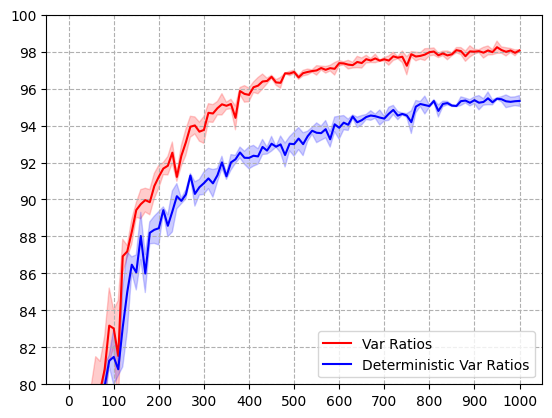

In [ ]:
vr_data = [[55.92, 59.69, 68.91, 71.66, 76.53, 80.29, 82.01, 80.63, 83.09, 85.89, 84.41, 85.7, 88.19, 87.61, 88.99, 89.97, 90.86, 90.54, 90.29, 91.69, 92.06, 92.13, 92.52, 93.14, 91.2, 92.08, 94.05, 93.34, 93.99, 93.24, 93.09, 94.23, 94.54, 94.89, 94.48, 94.83, 95.19, 95.2, 95.6, 95.16, 95.15, 95.93, 95.54, 95.81, 96.33, 96.52, 96.13, 96.27, 96.84, 96.65, 96.95, 96.6, 96.79, 96.71, 97.01, 96.63, 97.05, 96.91, 96.89, 96.85, 97.33, 97.25, 97.24, 97.14, 97.11, 97.28, 97.35, 97.42, 97.35, 97.56, 97.45, 97.24, 97.46, 97.6, 97.3, 97.37, 97.67, 97.54, 97.54, 97.39, 97.69, 97.73, 97.64, 97.73, 97.46, 97.76, 97.88, 97.76, 97.38, 97.58, 97.99, 97.97, 97.53, 97.88, 97.78, 97.78, 97.89, 97.69, 97.92, 97.71, 98.08], [56.51, 57.16, 59.52, 65.63, 74.88, 72.29, 79.49, 80.93, 78.7, 82.64, 82.12, 80.15, 86.56, 87.14, 88.39, 89.29, 89.19, 90.29, 88.89, 90.31, 91.06, 91.37, 91.61, 91.76, 90.94, 91.87, 92.35, 94.7, 93.45, 94.4, 94.77, 95.38, 95.29, 95.41, 95.89, 95.31, 94.84, 93.62, 96.02, 95.72, 95.81, 95.82, 96.44, 96.64, 96.28, 96.66, 96.37, 95.98, 96.83, 96.93, 96.76, 96.48, 96.68, 96.89, 96.98, 97.08, 97.26, 96.87, 97.21, 97.55, 97.57, 97.38, 97.61, 97.18, 97.36, 97.76, 97.57, 97.47, 97.63, 97.47, 97.64, 97.46, 97.77, 97.68, 97.83, 97.76, 97.89, 98.07, 97.81, 98.04, 98.17, 98.17, 97.95, 98.0, 97.98, 97.85, 98.17, 98.19, 98.05, 98.23, 98.16, 98.14, 98.17, 98.41, 98.11, 98.56, 98.31, 98.23, 98.19, 98.04, 98.11], [54.69, 59.43, 64.6, 66.49, 73.01, 77.2, 77.83, 77.47, 80.65, 80.99, 82.53, 78.75, 86.03, 86.81, 87.36, 89.03, 89.19, 89.07, 90.38, 90.18, 90.58, 91.52, 91.35, 92.7, 91.52, 93.14, 92.88, 93.77, 94.58, 93.37, 93.43, 94.46, 94.13, 94.52, 95.08, 95.07, 95.47, 94.43, 95.98, 96.26, 96.02, 96.47, 96.5, 96.7, 96.63, 96.73, 96.5, 96.69, 96.81, 96.86, 96.99, 96.74, 97.04, 97.1, 96.86, 97.24, 97.03, 97.27, 97.22, 96.81, 97.23, 97.46, 97.04, 97.49, 97.85, 97.11, 97.86, 97.67, 97.92, 97.51, 97.67, 97.85, 98.01, 97.74, 98.04, 96.58, 98.02, 97.6, 97.96, 98.09, 98.05, 98.12, 97.82, 97.98, 97.95, 97.96, 98.19, 98.14, 97.83, 98.23, 97.84, 97.97, 98.13, 97.9, 98.03, 98.38, 98.06, 98.05, 98.08, 98.06, 98.01]]
d_vr_data = [[51.56, 59.87, 63.45, 64.56, 71.84, 77.67, 76.19, 78.61, 80.63, 81.54, 81.81, 81.27, 85.59, 87.38, 86.41, 87.23, 89.54, 86.63, 88.98, 88.61, 89.72, 89.67, 87.76, 90.69, 89.23, 89.87, 90.34, 91.16, 91.23, 90.83, 90.03, 90.55, 90.49, 91.51, 91.85, 91.44, 91.6, 92.28, 92.37, 92.24, 91.69, 91.61, 91.88, 92.27, 92.6, 92.46, 92.89, 92.74, 91.99, 92.59, 92.19, 92.54, 92.31, 93.16, 93.46, 92.94, 93.05, 93.28, 93.47, 94.22, 93.01, 93.64, 94.08, 94.37, 94.04, 94.05, 94.28, 94.18, 94.51, 93.89, 94.31, 94.41, 94.98, 94.64, 94.57, 94.4, 93.37, 94.73, 95.15, 94.43, 94.96, 95.24, 95.24, 95.07, 95.1, 95.07, 95.0, 95.12, 95.17, 95.45, 95.14, 94.71, 95.46, 95.02, 95.44, 95.48, 95.26, 95.5, 94.93, 94.99, 94.98], [54.0, 61.77, 65.37, 72.91, 75.95, 74.15, 74.72, 77.99, 78.29, 81.42, 83.16, 80.72, 80.34, 82.14, 85.98, 84.91, 86.41, 84.54, 87.54, 87.36, 87.75, 89.25, 88.8, 89.4, 90.82, 90.13, 89.95, 91.43, 89.86, 91.08, 91.41, 91.88, 91.92, 91.63, 92.47, 91.04, 91.83, 92.37, 92.3, 92.7, 91.99, 92.96, 92.89, 93.05, 92.9, 93.2, 92.85, 93.62, 91.91, 92.94, 93.79, 94.0, 93.81, 93.8, 93.79, 93.64, 93.9, 94.42, 93.63, 93.52, 94.46, 94.57, 94.4, 94.54, 93.92, 94.64, 94.5, 94.68, 94.64, 94.88, 94.56, 94.36, 94.5, 94.23, 94.7, 94.61, 94.33, 95.49, 95.01, 95.53, 95.1, 95.44, 94.46, 95.06, 95.21, 95.03, 95.09, 95.65, 95.43, 95.03, 95.39, 95.63, 95.33, 95.54, 95.24, 95.39, 95.6, 95.61, 95.54, 95.42, 95.7], [53.59, 56.77, 65.37, 72.44, 71.92, 74.76, 75.69, 79.02, 80.82, 80.86, 79.47, 80.44, 83.34, 85.46, 87.02, 86.02, 88.12, 86.81, 88.07, 89.11, 87.86, 89.35, 89.17, 87.97, 90.48, 89.77, 90.54, 91.3, 89.81, 90.08, 91.21, 90.99, 90.21, 90.79, 91.7, 91.28, 92.59, 91.87, 92.96, 91.83, 93.07, 92.53, 92.22, 93.21, 92.44, 93.39, 92.83, 92.58, 93.32, 93.52, 93.0, 93.35, 92.86, 93.3, 93.91, 94.25, 93.82, 93.71, 92.67, 94.46, 94.17, 94.26, 93.65, 94.56, 94.57, 94.18, 94.61, 94.77, 94.37, 94.53, 94.26, 95.14, 95.06, 94.75, 94.62, 94.62, 94.85, 94.85, 95.34, 95.37, 95.1, 95.3, 94.67, 95.38, 95.34, 95.14, 95.09, 95.19, 95.46, 95.22, 95.59, 95.37, 95.04, 95.86, 95.1, 95.49, 95.41, 94.83, 95.38, 95.54, 95.32]]

plot_data = [
    {"data": vr_data, "label": "Var Ratios", "color": "red"},
    {"data": d_vr_data, "label": "Deterministic Var Ratios", "color": "blue"},
]

plot_graph(plot_data, std=True)

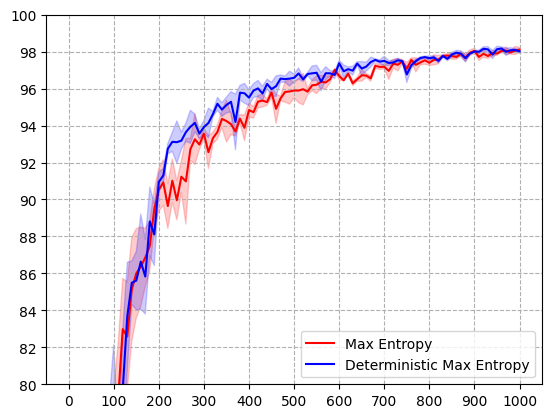

In [ ]:
me_data = [[52.49, 62.32, 60.88, 70.71, 74.13, 74.08, 72.66, 78.15, 80.83, 78.31, 80.66, 83.52, 85.71, 86.16, 89.08, 89.4, 89.34, 89.02, 89.33, 90.95, 92.17, 92.57, 90.69, 92.24, 90.24, 92.24, 93.04, 93.45, 94.08, 93.3, 93.14, 93.65, 93.34, 94.0, 94.71, 94.36, 94.8, 94.02, 94.05, 94.19, 94.48, 94.96, 95.78, 95.75, 95.25, 95.8, 95.7, 95.63, 96.26, 96.69, 96.35, 96.63, 96.59, 96.06, 96.43, 96.84, 96.78, 96.83, 96.77, 97.11, 96.84, 96.4, 96.72, 96.45, 96.47, 96.69, 96.75, 96.37, 97.42, 97.16, 97.05, 97.49, 97.65, 97.67, 97.61, 96.94, 97.71, 97.82, 97.3, 97.83, 97.59, 97.58, 97.88, 97.68, 97.9, 97.86, 97.88, 97.85, 97.38, 98.13, 97.85, 97.55, 97.71, 97.59, 97.74, 97.88, 98.05, 98.27, 97.84, 98.26, 98.29], [55.03, 52.78, 62.41, 67.0, 64.54, 71.34, 70.61, 72.54, 75.89, 74.2, 76.12, 77.48, 79.23, 78.92, 83.51, 83.94, 84.4, 86.29, 86.96, 88.42, 89.68, 89.59, 87.94, 89.43, 88.54, 90.12, 87.75, 91.98, 91.32, 92.97, 93.74, 92.56, 92.92, 93.13, 93.69, 92.8, 93.43, 93.54, 94.5, 92.91, 94.68, 94.28, 95.01, 95.38, 95.07, 95.47, 93.82, 95.45, 95.04, 95.02, 95.38, 95.04, 94.76, 95.63, 95.76, 95.68, 96.4, 96.07, 96.34, 97.0, 96.83, 96.46, 96.9, 96.13, 96.65, 96.34, 96.81, 96.75, 97.07, 97.01, 97.16, 96.37, 97.07, 96.86, 97.45, 96.73, 97.44, 97.09, 97.35, 97.39, 97.34, 97.88, 97.44, 97.84, 97.82, 97.53, 97.58, 98.04, 97.86, 97.75, 98.15, 97.98, 98.14, 97.79, 97.92, 97.79, 97.94, 98.11, 98.01, 98.17, 98.0], [52.11, 56.96, 59.87, 63.39, 65.15, 68.9, 72.36, 76.58, 76.82, 76.08, 75.68, 76.8, 84.01, 82.67, 82.8, 84.66, 85.35, 85.28, 86.18, 89.11, 89.74, 90.6, 90.3, 91.38, 91.09, 91.34, 92.15, 92.73, 94.38, 92.64, 93.79, 91.47, 93.7, 93.83, 94.68, 95.57, 94.0, 93.48, 94.55, 94.53, 95.36, 94.92, 95.1, 94.92, 95.49, 96.09, 95.2, 95.33, 96.16, 95.82, 95.96, 96.01, 96.55, 95.82, 96.34, 96.11, 95.93, 96.09, 96.42, 96.93, 96.38, 96.49, 96.81, 96.28, 96.4, 97.12, 96.56, 96.55, 97.21, 97.35, 97.34, 97.02, 97.34, 97.33, 97.33, 97.54, 97.52, 96.95, 97.59, 97.37, 97.26, 97.21, 97.38, 97.77, 97.64, 97.88, 97.68, 97.75, 97.78, 97.94, 98.13, 97.61, 97.8, 97.91, 98.1, 98.02, 98.11, 97.8, 98.01, 97.75, 98.04]]
d_me_data = [[53.06, 55.3, 62.56, 67.65, 72.47, 73.82, 74.65, 75.01, 77.91, 79.07, 81.37, 76.34, 82.49, 85.01, 86.53, 87.82, 89.06, 88.62, 91.35, 90.35, 90.94, 90.98, 92.37, 92.41, 91.65, 92.86, 93.29, 92.98, 94.56, 93.77, 93.57, 95.06, 94.43, 94.75, 94.64, 94.51, 94.87, 92.3, 95.26, 95.59, 95.46, 95.92, 95.46, 95.25, 95.94, 95.61, 95.52, 96.3, 96.39, 96.02, 96.6, 96.83, 96.65, 96.69, 96.26, 97.27, 95.81, 96.41, 96.74, 96.6, 97.3, 96.53, 97.02, 97.28, 97.38, 96.65, 97.47, 97.1, 97.48, 97.36, 97.15, 97.53, 97.35, 97.37, 97.46, 96.44, 97.05, 97.64, 97.55, 97.72, 97.47, 97.57, 97.35, 97.84, 97.54, 97.7, 97.88, 97.77, 97.59, 97.96, 98.07, 98.11, 98.22, 98.09, 98.15, 98.3, 98.26, 97.82, 98.27, 98.01, 98.09], [52.9, 57.01, 60.65, 58.89, 65.45, 67.7, 68.68, 72.91, 69.45, 73.61, 71.58, 73.01, 75.21, 79.6, 83.85, 84.73, 83.06, 83.9, 88.15, 87.68, 91.61, 91.07, 92.83, 93.66, 93.19, 93.84, 93.3, 93.69, 93.48, 93.18, 94.4, 94.25, 94.63, 95.6, 95.39, 95.44, 96.07, 95.99, 96.2, 96.47, 96.06, 96.34, 96.52, 96.21, 96.58, 96.48, 96.87, 96.78, 96.75, 97.0, 96.83, 97.18, 96.37, 96.78, 97.11, 96.99, 97.02, 97.29, 97.04, 96.59, 97.6, 97.36, 97.22, 96.94, 97.47, 97.04, 96.89, 97.76, 97.63, 97.43, 97.66, 97.41, 97.6, 97.58, 97.54, 96.47, 97.47, 97.4, 97.72, 97.76, 97.71, 97.77, 97.55, 97.67, 97.75, 97.83, 98.12, 98.11, 97.9, 97.83, 97.96, 97.88, 98.0, 98.32, 97.64, 97.91, 98.2, 97.89, 97.95, 98.2, 97.86], [56.06, 56.59, 65.92, 67.23, 70.04, 72.53, 74.61, 75.58, 74.95, 77.69, 80.33, 77.08, 81.48, 86.4, 86.1, 84.28, 87.79, 84.96, 86.94, 86.29, 90.3, 91.85, 93.05, 93.29, 94.46, 92.85, 94.33, 95.13, 94.39, 93.74, 93.79, 93.1, 94.8, 95.19, 94.56, 95.39, 94.92, 94.29, 95.88, 95.18, 95.02, 95.42, 96.05, 95.74, 96.23, 95.83, 96.0, 96.54, 96.4, 96.6, 96.32, 96.45, 96.48, 96.9, 97.11, 96.31, 96.28, 96.79, 96.7, 97.02, 97.22, 96.92, 96.92, 96.69, 97.22, 97.57, 97.21, 97.45, 97.55, 97.59, 97.69, 97.22, 97.29, 97.64, 97.46, 97.39, 97.27, 97.42, 97.69, 97.63, 97.76, 97.72, 97.6, 97.79, 97.54, 98.01, 97.83, 97.8, 97.44, 97.9, 97.99, 97.98, 98.24, 97.96, 97.74, 98.18, 98.05, 98.26, 98.01, 98.05, 98.1]]

plot_data = [
    {"data": me_data, "label": "Max Entropy", "color": "red"},
    {"data": d_me_data, "label": "Deterministic Max Entropy", "color": "blue"},
]

plot_graph(plot_data, std=True)